In [4]:
import autograd.numpy as np
import autograd.numpy.random as npr

from scipy.linalg import orthogonal_procrustes, norm
#matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

from ssm.models import HMM
from ssm.util import find_permutation

### e.g. parameters
npr.seed(1)

#### Generate an HMM
# Set the parameters of the HMM

T = 2000    # number of time bins
K = 17        # number of discrete states, e.g. location

### Poisson
D0 = 10  # number of tetrodes
D1 = 50 # max number of events (Poisson)
D2 = 3 # spike count dimension (per event 0 or 1) + two mark dimensions
D = (D0, D1, D2) # tuple


#### ###################
# Make an HMM
true_hmm = HMM(K, D, transitions='mazedistance', observations="clusterless")

# Sample some data from the HMM

z, y = true_hmm.sample(T)

# likelihood
true_ll = true_hmm.log_probability(y)

spikes = np.sum(y[:, :, :, 0], axis=2) # T by D0
marks = y[:, :, :, 1:] # T by D0 by D2 by D3

### true parameters ############
L = true_hmm.transitions.L  # length scale/smoothing
ell_labels = true_hmm.transitions.ell_labels # latent 2D space
log_p = true_hmm.params[1][1]

Ps = true_hmm.transitions.transition_matrix

In [5]:
### ############################################### ###
###        Fit an HMM to this synthetic data        ###
### ############################################### ###
    
N_iters = 30
hmm = HMM(K, D, transitions="mazedistance", observations="clusterless")
hmm_lls = hmm.fit(y, method="em", num_em_iters=N_iters)
#hmm_lls = hmm.fit(y)

# Find a permutation of the states that best matches the true and inferred states
hmm.permute(find_permutation(z, hmm.most_likely_states(y)))
hmm_z = hmm.most_likely_states(y)

##### ####################
### parameter estimates #################
L_hmm = hmm.transitions.L  # length scale/smoothing
ell_labels_hmm = hmm.transitions.ell_labels # latent 2D space
log_p_hmm = hmm.params[1][1]
Ps_hmm = hmm.transitions.transition_matrix

LP: -97125.1: 100%|████████████████████████████████████████████████████████████████████| 30/30 [10:46<00:00, 21.55s/it]


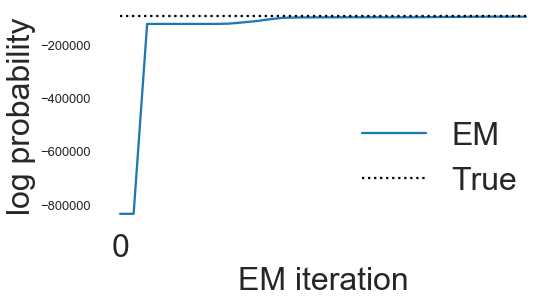

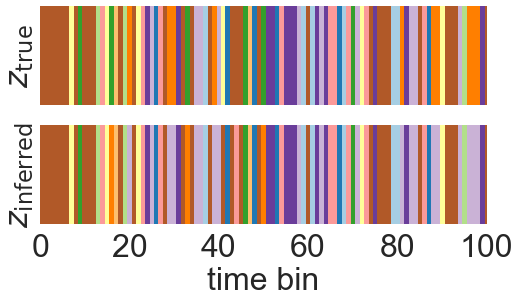

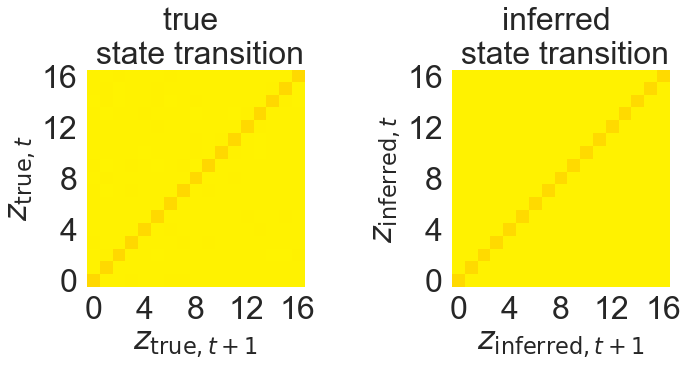

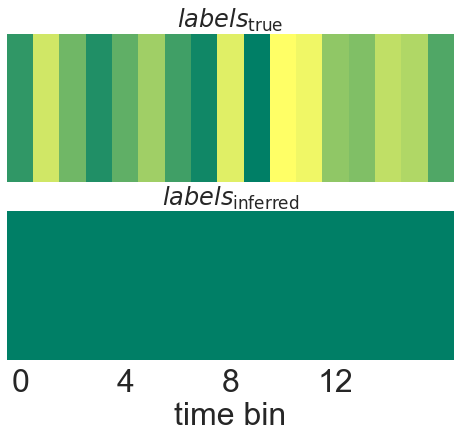

In [6]:
##### ####################
##### plot fitted results

import matplotlib.pyplot as plt

######### LogL
plt.figure(figsize=(8, 4))
plt.plot(hmm_lls, label="EM")
plt.plot([0, N_iters], true_ll * np.ones(2), ':k', label="True")
plt.xticks(np.arange(0, N_iters, step=40), fontsize=32)
plt.xlabel("EM iteration", fontsize=32)
plt.ylabel("log probability", fontsize=32)
plt.legend(loc="lower right", fontsize=32)
for spine in plt.gca().spines.values():
    spine.set_visible(False) 
plt.show()

######## Zs
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(z[None,:], cmap='Paired', vmin=0, vmax=D0, aspect="auto")
plt.xlim(0, 100)
plt.ylabel("$z_{\\mathrm{true}}$", fontsize=32)
plt.yticks([])
plt.xticks([])
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.subplot(212)
plt.imshow(hmm_z[None,:], cmap='Paired', vmin=0, vmax=D0, aspect="auto")
plt.xlim(0, 100)
plt.ylabel("$z_{\\mathrm{inferred}}$", fontsize=32)
plt.yticks([])
plt.xticks(np.arange(0, 100.01, step=20), fontsize=32)
plt.xlabel("time bin", fontsize=32)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()

##### Ps
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(Ps, cmap="autumn_r", vmin=0, vmax=1, aspect="equal")
plt.xlim(-.5,K-.5)
plt.ylim(-.5,K-.5)
plt.yticks(np.arange(0, K, step=4), fontsize=32)
plt.xticks(np.arange(0, K, step=4), fontsize=32)
plt.title("true \n state transition", fontsize=32)
plt.xlabel("$z_{\\mathrm{true},t+1}$", fontsize=32)
plt.ylabel("$z_{\\mathrm{true},t}$", fontsize=32)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.subplot(122)
plt.imshow(hmm.transitions.transition_matrix, cmap="autumn_r", vmin=0, vmax=1, aspect="equal")
plt.xlim(-.5,K-.5)
plt.ylim(-.5,K-.5)
plt.yticks(np.arange(0, K, step=4), fontsize=32)
plt.xticks(np.arange(0, K, step=4), fontsize=32)
plt.title("inferred \n state transition", fontsize=32)
plt.xlabel("$z_{\\mathrm{inferred},t+1}$", fontsize=32)
plt.ylabel("$z_{\\mathrm{inferred},t}$", fontsize=32)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.subplots_adjust(top=0.88) 
plt.show()

###### ell_labels
plt.figure(figsize=(8, 6))
plt.subplot(211)
plt.imshow(ell_labels[None,:], cmap='summer', vmin=0, vmax=K-1, aspect="auto")
plt.xlim(-0.5, K-0.5)
plt.title("$labels_{\\mathrm{true}}$", fontsize=24)
plt.yticks([])
plt.xticks([])
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.subplot(212)
plt.imshow(ell_labels_hmm[None,:], cmap='summer', vmin=0, vmax=K-1, aspect="auto")
plt.xlim(-0.5, K-0.5)
plt.xticks(np.arange(0, K-1, step=4), fontsize=32)
plt.title("$labels_{\\mathrm{inferred}}$", fontsize=24)
plt.yticks([])
plt.xlabel("time bin", fontsize=32)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()